In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef

In [15]:
likelihood_df = pd.read_csv('predict_w_Hao_PreLect_top50_likelihood.csv', index_col=0)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
AAACATACACCCAA-1,1.055932e-19,1.000000,0.953149,1.025037e-19,2.383494e-10,1.101509e-13,3.695499e-21,1.081192e-03
AAACATACCCCTCA-1,1.922833e-33,0.999689,0.998860,7.930619e-30,1.298092e-11,9.833114e-22,4.044491e-31,5.129632e-08
AAACATACCGGAGA-1,3.740313e-36,1.000000,0.000458,7.263669e-36,9.195744e-13,5.463452e-32,9.730696e-29,3.547924e-16
AAACATACTAACCG-1,9.993695e-01,1.000000,0.003460,1.613095e-02,1.142677e-08,3.982728e-09,1.492544e-11,9.780305e-05
AAACATACTCTTCA-1,7.041269e-28,1.000000,0.981772,1.183579e-17,9.094504e-08,6.331480e-12,1.038114e-16,2.017316e-03


In [4]:
likelihood_df.sum(axis=1)

AAACATACACCCAA-1    1.954231
AAACATACCCCTCA-1    1.998549
AAACATACCGGAGA-1    1.000458
AAACATACTAACCG-1    2.019058
AAACATACTCTTCA-1    1.983789
                      ...   
TTTGCATGAGCCTA-8    1.999563
TTTGCATGCTAGCA-8    2.178249
TTTGCATGCTGCAA-8    0.168826
TTTGCATGGCTCCT-8    0.015731
TTTGCATGTGGTAC-8    1.000222
Length: 68579, dtype: float64

In [5]:
# Read Zheng query dataset
query_adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
query_adata.shape

(68579, 32738)

In [6]:
query_adata.obs.head()

,celltype,TSNE.1,TSNE.2
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970


In [9]:
unique_types = query_adata.obs['celltype'].unique().tolist()
super_type_dict = {unique_types[0]: 'CD8_T', 
                   unique_types[1]: 'CD8_T', 
                   unique_types[2]: 'CD4_T', 
                   unique_types[3]: 'B', 
                   unique_types[4]: 'CD4_T', 
                   unique_types[5]: 'NK', 
                   unique_types[6]: 'CD4_T',
                   unique_types[7]: 'CD4_T',
                   unique_types[8]: 'other_T',
                   unique_types[9]: 'DC', 
                   unique_types[10]: 'Mono',}
super_type_dict

{'CD8+ Cytotoxic T': 'CD8_T',
 'CD8+/CD45RA+ Naive Cytotoxic': 'CD8_T',
 'CD4+/CD45RO+ Memory': 'CD4_T',
 'CD19+ B': 'B',
 'CD4+/CD25 T Reg': 'CD4_T',
 'CD56+ NK': 'NK',
 'CD4+ T Helper2': 'CD4_T',
 'CD4+/CD45RA+/CD25- Naive T': 'CD4_T',
 'CD34+': 'other_T',
 'Dendritic': 'DC',
 'CD14+ Monocyte': 'Mono'}

In [10]:
# Map from "celltype" to "super_type" using the dictionary
query_adata.obs['super_type'] = query_adata.obs['celltype'].map(super_type_dict)
query_adata.obs.head()

,celltype,TSNE.1,TSNE.2,super_type
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,CD8_T
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,CD8_T
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,CD4_T
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,B
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,CD4_T


In [16]:
# Add "assignment" column with the column name of the max value in each row
assignment_df = pd.DataFrame({'assignment': likelihood_df.idxmax(axis=1), 
                              'super_type': query_adata.obs['super_type']})
assignment_df.head()

,assignment,super_type
AAACATACACCCAA-1,CD4_T,CD8_T
AAACATACCCCTCA-1,CD4_T,CD8_T
AAACATACCGGAGA-1,CD4_T,CD4_T
AAACATACTAACCG-1,CD4_T,B
AAACATACTCTTCA-1,CD4_T,CD4_T


In [17]:
assignment_df['assignment'].value_counts()

assignment
CD4_T      49196
CD8_T      14244
Mono        1657
DC          1585
NK           859
other        646
other_T      202
B            190
Name: count, dtype: int64

In [18]:
query_adata.obs['super_type'].value_counts()

super_type
CD8_T      37439
CD4_T      11218
NK          8776
B           5908
Mono        2862
DC          2099
other_T      277
Name: count, dtype: int64

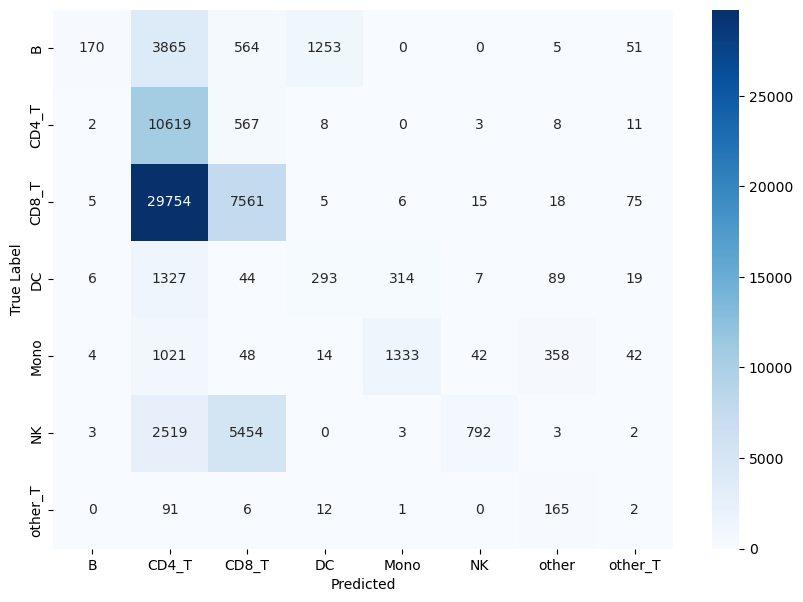

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the confusion matrix
# cm = confusion_matrix(assignment_df['super_type'], assignment_df['assignment'])  # (label, predicted)
cm = pd.crosstab(assignment_df['super_type'], assignment_df['assignment'])
cm

# Plot the confusion matrix
plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(assignment_df['assignment']), yticklabels=set(assignment_df['assignment']))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [26]:
# Calculate the accuracy
# devide the sum of the diagonal by the sum of all elements
accuracy = np.trace(cm) / np.sum(cm.values)
accuracy

0.30523921317021246